En esta libreta vamos a leer la información descargada de CDMXTravel de la carpeta `data` para generar las tablas de datos que conformarán nuestra base de conocimientos.

In [1]:
import os
import os.path
import re
import json
import unicodedata

In [2]:
files_iter = list(filter(os.path.isfile, map(lambda x: 'data/' + x, os.listdir('data'))))

In [3]:
place_re = re.compile('/\d+_\d+_info.json$')
destination_re = re.compile('/\d+_info.json$')

In [4]:
def open_json(path):
    with open(path) as infile:
        return json.load(infile)

In [5]:
price_re = re.compile('^desde \$[\d,]+ mxn')

def valid(x):
    return x not in [None, '', []]

def normalizer(x):
    if not valid(x):
        return None
    return unicodedata.normalize('NFKC', x.strip().lower())

def clean_place(place):
    data = {
        'Place': normalizer(place['name']),
        'Destination': normalizer(place['destination']),
        'Labels': [normalizer(x) for x in place['labels']] if valid(place['labels']) else None,
        'Categories': [normalizer(x) for x in place['categories']] if valid(place['categories']) else None,
        'Price': normalizer(place['price']),
        'Schedule': place['schedule'] if valid(place['schedule']) else None,
        'Contact': place['contact'] if valid(place['contact']) else None,
        'Description': normalizer(place['description']),
        'External URLs': place['external_urls'] if valid(place['external_urls']) else None,
        'URL': place['url'] if valid(place['url']) else None
    }
    if valid(place['location']):
        data['Address'] = place['location']['address'] if valid(place['location']['address']) else None
        map_url = place['location']['map_url'] if valid(place['location']['map_url']) else None
        if map_url:
            if data['External URLs']:
                data['External URLs'].append(map_url)
            else:
                data['External URLs'] = [map_url]
    else:
        data['Address'] = None
        data['Map URL'] = None
    if data['Price']:
        if data['Price'] == 'gratuito':
            data['Price'] = 0
        elif price_re.search(data['Price']):
            data['Price'] = int(data['Price'][7:][:-4].replace(',', ''))
    if not data['Schedule']:
        data['Schedule'] = [None, None, None, None, None, None, None]
    return data

def clean_destination(destination):
    data = {
        'Destination': normalizer(destination['name']),
        'Description': normalizer(destination['description']),
        'URL': destination['url'] if valid(destination['url']) else None
    }
    return data

In [6]:
places = list(map(clean_place, map(open_json, filter(lambda x: place_re.search(x), files_iter))))
destinations = list(map(clean_destination, map(open_json, filter(lambda x: destination_re.search(x), files_iter))))

In [7]:
import pandas as pd

In [8]:
destdf = pd.DataFrame(destinations)
destdf.set_index('Destination', inplace=True)
destdf.head(3)

Description  \
Destination                                                      
anzures      aquí se respira el aire del bosque de chapulte...   
culhuacán    bajo el cerro de la estrella, donde se celebra...   
condesa      éste barrio burgués, residencia de artistas co...   

                                                          URL  
Destination                                                    
anzures        http://cdmxtravel.com/es/destinos/anzures.html  
culhuacán    http://cdmxtravel.com/es/destinos/culhuacan.html  
condesa        http://cdmxtravel.com/es/destinos/condesa.html

In [9]:
placdf = pd.DataFrame(places, columns=['Place', 'Destination', 'Address', 'Price', 'Contact', 'Description', 'URL'])
placdf.set_index('Place', inplace=True)
placdf.head(3)

Destination  \
Place                                        
cervecería de barrio roma          condesa   
centro cultural ollin yoliztli     tlalpan   
mercado san camilito                 norte   

                                                                          Address  \
Place                                                                               
cervecería de barrio roma           Durango #192, Col. Roma Norte. 06700, Condesa   
centro cultural ollin yoliztli  Anillo Periférico Sur #5141, Col. Isidro Fabe...   
mercado san camilito               Plaza Garibaldi s/n, Col. Centro. 06000, Norte   

                                Price             Contact  \
Place                                                       
cervecería de barrio roma       250.0  +52 (55) 5533 7674   
centro cultural ollin yoliztli    0.0      (55) 5606 0016   
mercado san camilito              NaN                None   

                                                                      Description  \
Place                                                                               
cervecería de barrio roma       un lugar alejado de los bares o antros de cade...   
centro cultural ollin yoliztli  el centro cultural se creó en 1979 y desde ent...   
mercado san camilito            este mercado fue inaugurado como una extensión...   

                                                                              URL  
Place                                                                              
cervecería de barrio roma       http://cdmxtravel.com/es/lugares/cerveceria-de...  
centro cultural ollin yoliztli  http://cdmxtravel.com/es/lugares/centro-cultur...  
mercado san camilito            http://cdmxtravel.com/es/lugares/mercado-san-c...

In [10]:
tags = set()
for place in places:
    if place['Labels']:
        tags = tags.union(place['Labels'])
    if place['Categories']:
        tags = tags.union(place['Categories'])
tags_membership = {'Place': list(map(lambda x: x['Place'], places))}
for tag in tags:
    tags_membership[tag] = []
for tag in tags:
    for place in places:
        if place['Labels'] and tag in place['Labels']:
            tags_membership[tag].append(1)
        elif place['Categories'] and tag in place['Categories']:
            tags_membership[tag].append(1)
        else:
            tags_membership[tag].append(0)
place_tags = pd.DataFrame(tags_membership)
place_tags.set_index('Place', inplace=True)
place_tags.head(3)

centros de entretenimiento familiares  \
Place                                                                   
cervecería de barrio roma                                           0   
centro cultural ollin yoliztli                                      0   
mercado san camilito                                                0   

                                comercios centenarios  bar  arqueología  \
Place                                                                     
cervecería de barrio roma                           0    1            0   
centro cultural ollin yoliztli                      0    0            0   
mercado san camilito                                1    0            0   

                                zoológicos  vive la noche  museos  cantina  \
Place                                                                        
cervecería de barrio roma                0              1       0        0   
centro cultural ollin yoliztli           0              0       1        0   
mercado san camilito                     0              0       0        0   

                                pistas de patinaje  estadios y arenas  ...  \
Place                                                                  ...   
cervecería de barrio roma                        0                  0  ...   
centro cultural ollin yoliztli                   0                  0  ...   
mercado san camilito                             0                  0  ...   

                                casinos  mezcalería  en familia  huertos  \
Place                                                                      
cervecería de barrio roma             0           0           0        0   
centro cultural ollin yoliztli        0           0           0        0   
mercado san camilito                  0           0           0        0   

                                bingos y salas de juegos  antro  hemerotecas  \
Place                                                                          
cervecería de barrio roma                              0      0            0   
centro cultural ollin yoliztli                         0      0            0   
mercado san camilito                                   0      0            0   

                                delegaciones  centros nocturnos  cines de arte  
Place                                                                           
cervecería de barrio roma                  0                  0              0  
centro cultural ollin yoliztli             0                  0              0  
mercado san camilito                       0                  0              0  

[3 rows x 100 columns]

¿Qué palabras debemos de incluir en la lista de stopwords?

In [10]:
import string
import nltk
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.data.path.append('nltk_data')
stemmer = SnowballStemmer('spanish') # stemmer.stem('word')

In [19]:
stemmer.stem(stemmer.stem('correr'))

'corr'

In [12]:
additional_stop_words = set([
    'más', 'méxico', 'lugar', 'cuenta', 'también', 'además', 'encuentra', 'está',
    'ofrece', 'parte', 'puede', 'así', 'dos', 'pueden', 'nombre', 'ser', 'través',
    'caso', 'casos', 'cada', 'ahí', 'ubica', 'tres', 'aquí', 'solo', 'à', 'acá', 'cd',
    '›'
])
stop_words = set(stopwords.words('spanish')).union(additional_stop_words)

In [13]:
usual_words = re.compile('^[a-zA-ZáéíóúÁÉÍÓÚñÑüÜ ]+$')
def normalize_text(src_txt):
    txt = unicodedata.normalize('NFKC', src_txt.strip())
    txt = txt.lower()
    txt = re.sub(f'[{re.escape(string.punctuation)}¡¿—–\u200b]', ' ', txt)
    txt = re.sub('\w*\d\w*', '', txt)
    txt = re.sub('[‘’“”\xad]', '', txt)
    txt = word_tokenize(txt, language='spanish')
    words = [stemmer.stem(word) for word in txt if word not in stop_words and len(word) > 2 and usual_words.match(word)]
    return words

In [14]:
from collections import Counter

In [15]:
wordcount = Counter()

In [16]:
for (place_name, description) in placdf['Description'].iteritems():
    if description:
        wordcount.update(normalize_text(description))
    wordcount.update(normalize_text(place_name))
for (dest_name, description) in destdf['Description'].iteritems():
    wordcount.update(normalize_text(description))
    wordcount.update(normalize_text(dest_name))

In [17]:
# Listo: se revisan las 100 palabras que se usan con más frecuencia hasta que tengamos un top 100 que no contenga basurita
# wordcount.most_common(100)

In [18]:
# Pendiente: checar si hay caracteres raros (fuera de letras de ascii y acentos del español)
# wordcount.most_common()[-1000:]
# usual_words = re.compile('^[a-zA-ZáéíóúÁÉÍÓÚñÑüÜ ]+$')
# [word for word in wordcount if len(word) == 2]

In [19]:
all_words = [word for word in wordcount]

In [20]:
tags = set()
for place in places:
    if place['Labels']:
        tags = tags.union(place['Labels'])
    if place['Categories']:
        tags = tags.union(place['Categories'])
tags_membership = {'Place': list(map(lambda x: x['Place'], places))}
for tag in tags:
    tags_membership[tag] = []
for tag in tags:
    for place in places:
        if place['Labels'] and tag in place['Labels']:
            tags_membership[tag].append(1)
        elif place['Categories'] and tag in place['Categories']:
            tags_membership[tag].append(1)
        else:
            tags_membership[tag].append(0)
place_tags = pd.DataFrame(tags_membership)
place_tags.set_index('Place', inplace=True)
place_tags.head(3)

centros de entretenimiento familiares  \
Place                                                                   
cervecería de barrio roma                                           0   
centro cultural ollin yoliztli                                      0   
mercado san camilito                                                0   

                                comercios centenarios  bar  arqueología  \
Place                                                                     
cervecería de barrio roma                           0    1            0   
centro cultural ollin yoliztli                      0    0            0   
mercado san camilito                                1    0            0   

                                zoológicos  vive la noche  museos  cantina  \
Place                                                                        
cervecería de barrio roma                0              1       0        0   
centro cultural ollin yoliztli           0              0       1        0   
mercado san camilito                     0              0       0        0   

                                pistas de patinaje  estadios y arenas  ...  \
Place                                                                  ...   
cervecería de barrio roma                        0                  0  ...   
centro cultural ollin yoliztli                   0                  0  ...   
mercado san camilito                             0                  0  ...   

                                casinos  mezcalería  en familia  huertos  \
Place                                                                      
cervecería de barrio roma             0           0           0        0   
centro cultural ollin yoliztli        0           0           0        0   
mercado san camilito                  0           0           0        0   

                                bingos y salas de juegos  antro  hemerotecas  \
Place                                                                          
cervecería de barrio roma                              0      0            0   
centro cultural ollin yoliztli                         0      0            0   
mercado san camilito                                   0      0            0   

                                delegaciones  centros nocturnos  cines de arte  
Place                                                                           
cervecería de barrio roma                  0                  0              0  
centro cultural ollin yoliztli             0                  0              0  
mercado san camilito                       0                  0              0  

[3 rows x 100 columns]

In [21]:
import numpy as np

In [60]:
place_words = pd.DataFrame({'Place': list(map(lambda x: x['Place'], places))})
place_words.set_index('Place', inplace=True)
size = len(place_words)
for word in all_words:
    place_words[word] = np.zeros(size)

In [61]:
place_words

alej  bar  antros  caden  \
Place                                                                          
cervecería de barrio roma                            0.0  0.0     0.0    0.0   
centro cultural ollin yoliztli                       0.0  0.0     0.0    0.0   
mercado san camilito                                 0.0  0.0     0.0    0.0   
ángulo cero                                          0.0  0.0     0.0    0.0   
videoteca manuel álvarez bravo                       0.0  0.0     0.0    0.0   
...                                                  ...  ...     ...    ...   
"la humanidad se libera de la miseria" de jorge...   0.0  0.0     0.0    0.0   
cinenauta                                            0.0  0.0     0.0    0.0   
biblioteca nacional de méxico                        0.0  0.0     0.0    0.0   
miranda & próspero bar                               0.0  0.0     0.0    0.0   
chuchito pérez cibeles                               0.0  0.0     0.0    0.0   

                                                    trat  ambient  tabern  \
Place                                                                       
cervecería de barrio roma                            0.0      0.0     0.0   
centro cultural ollin yoliztli                       0.0      0.0     0.0   
mercado san camilito                                 0.0      0.0     0.0   
ángulo cero                                          0.0      0.0     0.0   
videoteca manuel álvarez bravo                       0.0      0.0     0.0   
...                                                  ...      ...     ...   
"la humanidad se libera de la miseria" de jorge...   0.0      0.0     0.0   
cinenauta                                            0.0      0.0     0.0   
biblioteca nacional de méxico                        0.0      0.0     0.0   
miranda & próspero bar                               0.0      0.0     0.0   
chuchito pérez cibeles                               0.0      0.0     0.0   

                                                    europe  imper  buen  ...  \
Place                                                                    ...   
cervecería de barrio roma                              0.0    0.0   0.0  ...   
centro cultural ollin yoliztli                         0.0    0.0   0.0  ...   
mercado san camilito                                   0.0    0.0   0.0  ...   
ángulo cero                                            0.0    0.0   0.0  ...   
videoteca manuel álvarez bravo                         0.0    0.0   0.0  ...   
...                                                    ...    ...   ...  ...   
"la humanidad se libera de la miseria" de jorge...     0.0    0.0   0.0  ...   
cinenauta                                              0.0    0.0   0.0  ...   
biblioteca nacional de méxico                          0.0    0.0   0.0  ...   
miranda & próspero bar                                 0.0    0.0   0.0  ...   
chuchito pérez cibeles                                 0.0    0.0   0.0  ...   

                                                    atardec  tlilhuac  haz  \
Place                                                                        
cervecería de barrio roma                               0.0       0.0  0.0   
centro cultural ollin yoliztli                          0.0       0.0  0.0   
mercado san camilito                                    0.0       0.0  0.0   
ángulo cero                                             0.0       0.0  0.0   
videoteca manuel álvarez bravo                          0.0       0.0  0.0   
...                                                     ...       ...  ...   
"la humanidad se libera de la miseria" de jorge...      0.0       0.0  0.0   
cinenauta                                               0.0       0.0  0.0   
biblioteca nacional de méxico                           0.0       0.0  0.0   
miranda & próspero bar                                  0.0       0.0  0.0   
chuchito pérez cibeles          

In [62]:
for place in places:
    row = place['Place']
    for word in normalize_text(row):
        place_words.at[row, word] += 1.5
    if place['Description']:
        for word in normalize_text(place['Description']):
            place_words.at[row, word] += 1.0
    for word in normalize_text(place['Destination']):
        place_words.at[row, word] += 1.0
    for word in normalize_text(destdf.loc[place['Destination']]['Description']):
        place_words.at[row, word] += 0.5

In [63]:
# Eliminar columnas de palabras con valores en 0 (no aparecen en ningun lugar, e.g. Anzures)
place_words = place_words.loc[:, (place_words != 0).any(axis=0)]

# Normalizamos cada lugar por la palabra más frecuente asociada a el
place_words_norm = place_words / place_words.max()
place_words_norm

alej  bar    antros  \
Place                                                                     
cervecería de barrio roma                            1.0  0.3  1.000000   
centro cultural ollin yoliztli                       0.0  0.0  0.000000   
mercado san camilito                                 0.0  0.0  0.000000   
ángulo cero                                          0.0  0.1  0.333333   
videoteca manuel álvarez bravo                       0.0  0.0  0.000000   
...                                                  ...  ...       ...   
"la humanidad se libera de la miseria" de jorge...   0.0  0.0  0.000000   
cinenauta                                            0.0  0.0  0.000000   
biblioteca nacional de méxico                        0.0  0.0  0.000000   
miranda & próspero bar                               0.0  0.6  0.333333   
chuchito pérez cibeles                               0.0  0.1  0.333333   

                                                    caden  trat   ambient  \
Place                                                                       
cervecería de barrio roma                             0.5   0.5  0.500000   
centro cultural ollin yoliztli                        0.0   0.0  0.166667   
mercado san camilito                                  0.0   0.0  0.000000   
ángulo cero                                           0.0   0.0  0.000000   
videoteca manuel álvarez bravo                        0.0   0.0  0.000000   
...                                                   ...   ...       ...   
"la humanidad se libera de la miseria" de jorge...    0.0   0.0  0.166667   
cinenauta                                             0.0   0.0  0.166667   
biblioteca nacional de méxico                         0.0   0.0  0.000000   
miranda & próspero bar                                0.0   0.0  0.333333   
chuchito pérez cibeles                                0.0   0.0  0.500000   

                                                      tabern  europe  imper  \
Place                                                                         
cervecería de barrio roma                           0.666667     1.0    1.0   
centro cultural ollin yoliztli                      0.000000     0.0    0.0   
mercado san camilito                                0.000000     0.0    0.0   
ángulo cero                                         0.000000     0.0    0.0   
videoteca manuel álvarez bravo                      0.000000     0.0    0.0   
...                                                      ...     ...    ...   
"la humanidad se libera de la miseria" de jorge...  0.000000     0.0    0.0   
cinenauta                                           0.000000     0.0    0.0   
biblioteca nacional de méxico                       0.000000     0.0    0.0   
miranda & próspero bar                              0.000000     0.0    0.0   
chuchito pérez cibeles                              0.000000     0.0    0.0   

                                                     buen  ...  atardec  \
Place                                                      ...            
cervecería de barrio roma                           0.250  ...      0.0   
centro cultural ollin yoliztli                      0.000  ...      0.0   
mercado san camilito                                0.125  ...      0.0   
ángulo cero                                         0.000  ...      0.0   
videoteca manuel álvarez bravo                      0.000  ...      0.0   
...                                                   ...  ...      ...   
"la humanidad se libera de la miseria" de jorge...  0.000  ...      0.0   
cinenauta                                           0.000  ...      0.0   
biblioteca nacional de méxico                       0.250  ...      0.0   
miranda & próspero bar                              0.000  ...      0.0   
chuchito pérez cibeles                              0.000  ...      0.0   

                                                    tlilhuac  haz  her

In [171]:
tag_words = pd.DataFrame({'Tag': list(tags)})
tag_words.set_index('Tag', inplace=True)
size = len(tag_words)
for word in place_words_norm.columns:
    tag_words[word] = np.zeros(size)

In [172]:
tag_words

alej  bar  antros  caden  trat  \
Tag                                                                     
centros de entretenimiento familiares   0.0  0.0     0.0    0.0   0.0   
comercios centenarios                   0.0  0.0     0.0    0.0   0.0   
bar                                     0.0  0.0     0.0    0.0   0.0   
arqueología                             0.0  0.0     0.0    0.0   0.0   
zoológicos                              0.0  0.0     0.0    0.0   0.0   
...                                     ...  ...     ...    ...   ...   
antro                                   0.0  0.0     0.0    0.0   0.0   
hemerotecas                             0.0  0.0     0.0    0.0   0.0   
delegaciones                            0.0  0.0     0.0    0.0   0.0   
centros nocturnos                       0.0  0.0     0.0    0.0   0.0   
cines de arte                           0.0  0.0     0.0    0.0   0.0   

                                       ambient  tabern  europe  imper  buen  \
Tag                                                                           
centros de entretenimiento familiares      0.0     0.0     0.0    0.0   0.0   
comercios centenarios                      0.0     0.0     0.0    0.0   0.0   
bar                                        0.0     0.0     0.0    0.0   0.0   
arqueología                                0.0     0.0     0.0    0.0   0.0   
zoológicos                                 0.0     0.0     0.0    0.0   0.0   
...                                        ...     ...     ...    ...   ...   
antro                                      0.0     0.0     0.0    0.0   0.0   
hemerotecas                                0.0     0.0     0.0    0.0   0.0   
delegaciones                               0.0     0.0     0.0    0.0   0.0   
centros nocturnos                          0.0     0.0     0.0    0.0   0.0   
cines de arte                              0.0     0.0     0.0    0.0   0.0   

                                       ...  atardec  tlilhuac  haz  \
Tag                                    ...                           
centros de entretenimiento familiares  ...      0.0       0.0  0.0   
comercios centenarios                  ...      0.0       0.0  0.0   
bar                                    ...      0.0       0.0  0.0   
arqueología                            ...      0.0       0.0  0.0   
zoológicos                             ...      0.0       0.0  0.0   
...                                    ...      ...       ...  ...   
antro                                  ...      0.0       0.0  0.0   
hemerotecas                            ...      0.0       0.0  0.0   
delegaciones                           ...      0.0       0.0  0.0   
centros nocturnos                      ...      0.0       0.0  0.0   
cines de arte                          ...      0.0       0.0  0.0   

                                       hermosisim  caprich  plazolet  catolic  \
Tag                                                                             
centros de entretenimiento familiares         0.0      0.0       0.0      0.0   
comercios centenarios                         0.0      0.0       0.0      0.0   
bar                                           0.0      0.0       0.0      0.0   
arqueología                                   0.0      0.0       0.0      0.0   
zoológicos                                    0.0      0.0       0.0      0.0   
...                                           ...      ...       ...      ...   
antro                                         0.0      0.0       0.0      0.0   
hemerotecas                                   0.0      0.0       0.0      0.0   
delegaciones                                  0.0      0.0       0.0      0.0   
centros nocturnos                             0.0      0.0       0.0      0.0   
cines de arte                                 0.0      0.0       0.0      0.0   

                                       baptisteri  semi  oliv  
Tag                             

In [173]:
for place, words in place_words_norm.iterrows():
    columns = place_tags.columns[place_tags.loc[place] == 1]
    denom = len(columns)
    for tag in columns:
        tag_words.loc[tag, :] += (place_words_norm.loc[place] / denom)

In [174]:
tag_words

alej        bar     antros  \
Tag                                                                     
centros de entretenimiento familiares  0.342857   0.292358   0.971826   
comercios centenarios                  0.000000   0.073611   0.245370   
bar                                    2.000000  11.617311  14.470005   
arqueología                            0.000000   0.000000   0.000000   
zoológicos                             0.200000   0.000000   0.000000   
...                                         ...        ...        ...   
antro                                  0.000000   1.510556   2.968519   
hemerotecas                            0.000000   0.000000   0.000000   
delegaciones                           0.000000   0.010000   0.000000   
centros nocturnos                      0.000000   0.634444   1.793386   
cines de arte                          0.000000   0.359091   0.863636   

                                          caden      trat    ambient  \
Tag                                                                    
centros de entretenimiento familiares  1.467604  0.733637   1.451359   
comercios centenarios                  0.028490  0.172439   0.193137   
bar                                    3.375000  3.445833  12.958730   
arqueología                            0.075926  0.212121   0.109707   
zoológicos                             0.131548  0.100000   0.172222   
...                                         ...       ...        ...   
antro                                  0.625000  0.354167   2.430556   
hemerotecas                            0.017857  0.000000   0.046154   
delegaciones                           0.031250  0.000000   0.311895   
centros nocturnos                      0.125000  0.729167   1.345370   
cines de arte                          0.333333  0.250000   0.692460   

                                         tabern    europe  imper      buen  \
Tag                                                                          
centros de entretenimiento familiares  0.000000  0.502381    0.0  0.358833   
comercios centenarios                  0.000000  0.000000    0.0  0.231845   
bar                                    1.422222  3.533333    2.0  3.472514   
arqueología                            0.000000  0.000000    0.0  0.087500   
zoológicos                             0.000000  0.142857    0.0  0.012500   
...                                         ...       ...    ...       ...   
antro                                  0.000000  0.333333    0.0  0.333333   
hemerotecas                            0.000000  0.000000    0.0  0.000000   
delegaciones                           0.000000  0.000000    0.0  0.152778   
centros nocturnos                      0.000000  0.000000    0.0  0.343750   
cines de arte                          0.000000  0.000000    0.0  0.125000   

                                       ...   atardec  tlilhuac       haz  \
Tag                                    ...                                 
centros de entretenimiento familiares  ...  0.574679       0.0  0.486237   
comercios centenarios                  ...  0.000000       0.2  0.336601   
bar                                    ...  1.500000       0.0  2.800000   
arqueología                            ...  0.000000       0.0  0.333333   
zoológicos                             ...  0.000000       0.0  0.000000   
...                                    ...       ...       ...       ...   
antro                                  ...  0.000000       0.0  0.333333   
hemerotecas                            ...  0.000000       0.0  0.276923   
delegaciones                           ...  0.000000       0.5  0.000000   
centros nocturnos                      ...  1.200000       0.0  0.000000   
cines de arte                          ...  0.000000       0.0  0.500000   

                                       hermosisim   caprich  plazolet  \
Tag                                                                     
centro

In [175]:
# for row in tag_words.index:
#     tag_words.loc[row, :] += place_words_norm.loc[place_tags[row] == 1].sum()

In [185]:
# Eliminar columnas de palabras con valores en 0 (no aparecen en ninguna etiqueta)
tag_words = tag_words.loc[:, (tag_words != 0).any(axis=0)]
# Normalizamos cada etiqueta por la palabra más frecuente asociada a el
tag_words_norm = tag_words / tag_words.max()
tag_words_norm

alej       bar    antros     caden  \
Tag                                                                             
centros de entretenimiento familiares  0.171429  0.021700  0.050122  0.258263   
comercios centenarios                  0.000000  0.005464  0.012655  0.005014   
bar                                    1.000000  0.862275  0.746287  0.593919   
arqueología                            0.000000  0.000000  0.000000  0.013361   
zoológicos                             0.100000  0.000000  0.000000  0.023149   
...                                         ...       ...       ...       ...   
antro                                  0.000000  0.112118  0.153101  0.109985   
hemerotecas                            0.000000  0.000000  0.000000  0.003142   
delegaciones                           0.000000  0.000742  0.000000  0.005499   
centros nocturnos                      0.000000  0.047091  0.092494  0.021997   
cines de arte                          0.000000  0.026653  0.044542  0.058659   

                                           trat   ambient    tabern    europe  \
Tag                                                                             
centros de entretenimiento familiares  0.160504  0.084769  0.000000  0.142183   
comercios centenarios                  0.037726  0.011280  0.000000  0.000000   
bar                                    0.753874  0.756872  0.810127  1.000000   
arqueología                            0.046408  0.006408  0.000000  0.000000   
zoológicos                             0.021878  0.010059  0.000000  0.040431   
...                                         ...       ...       ...       ...   
antro                                  0.077484  0.141960  0.000000  0.094340   
hemerotecas                            0.000000  0.002696  0.000000  0.000000   
delegaciones                           0.000000  0.018217  0.000000  0.000000   
centros nocturnos                      0.159526  0.078578  0.000000  0.000000   
cines de arte                          0.054695  0.040444  0.000000  0.000000   

                                       imper      buen  ...   atardec  \
Tag                                                     ...             
centros de entretenimiento familiares    0.0  0.068754  ...  0.194807   
comercios centenarios                    0.0  0.044423  ...  0.000000   
bar                                      1.0  0.665355  ...  0.508475   
arqueología                              0.0  0.016766  ...  0.000000   
zoológicos                               0.0  0.002395  ...  0.000000   
...                                      ...       ...  ...       ...   
antro                                    0.0  0.063869  ...  0.000000   
hemerotecas                              0.0  0.000000  ...  0.000000   
delegaciones                             0.0  0.029273  ...  0.000000   
centros nocturnos                        0.0  0.065865  ...  0.406780   
cines de arte                            0.0  0.023951  ...  0.000000   

                                       tlilhuac       haz  hermosisim  \
Tag                                                                     
centros de entretenimiento familiares  0.000000  0.047776    0.047776   
comercios centenarios                  0.066667  0.033073    0.033073   
bar                                    0.000000  0.275120    0.275120   
arqueología                            0.000000  0.032752    0.032752   
zoológicos                             0.000000  0.000000    0.000000   
...                                         ...       ...         ...   
antro                                  0.000000  0.032752    0.032752   
hemerotecas                            0.000000  0.027210    0.027210   
delegaciones                           0.166667  0.000000    0.000000   
centros nocturnos                      0.000000  0.000000    0.000000   
cines de arte                          0.000000  0.049129    0.049129   

                                   

In [186]:
# ¿Qué tan distante está una etiqueta de otra?
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt
import seaborn as sb

In [187]:
tag_words_norm.values.shape

(100, 8339)

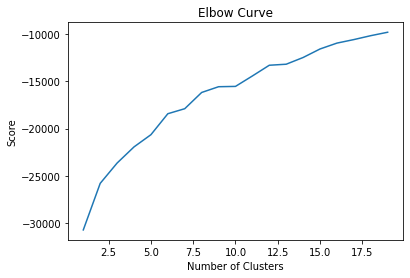

In [188]:
X = tag_words_norm.values
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [190]:
kmeans = KMeans(n_clusters=4).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.1031746  0.04574197 0.12499013 ... 0.46118721 0.49673203 0.49673203]
 [0.5        0.15653162 0.43342629 ... 0.1369863  0.09803922 0.09803922]
 [0.11825397 0.05878388 0.10216954 ... 0.02283105 0.34640523 0.34640523]
 [0.04978836 0.03966022 0.05698428 ... 0.01354642 0.02461874 0.02461874]]


In [191]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_

In [192]:
grupos = pd.DataFrame({'Tag': tag_words_norm.index, 'Group': labels}).set_index('Tag')

In [193]:
grupos.loc['méxico monumental']

Group    0
Name: méxico monumental, dtype: int32

In [197]:
grupos[grupos['Group'] == 3]

Group
Tag                         
comercios centenarios      3
bar                        3
arqueología                3
zoológicos                 3
vive la noche              3
...                      ...
antro                      3
hemerotecas                3
delegaciones               3
centros nocturnos          3
cines de arte              3

[90 rows x 1 columns]

In [59]:
tag_words_norm.loc['méxico monumental'].index[19]

'origen'

In [95]:
len((place_tags == 0).any(axis=1))

(place_tags == 0).all(axis=0).values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])